In [67]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Numeric Transformer 

AbstarctFeatureToNumericTransformer, LevelToNumericTransformer, BinaryToNumericTransformer, CyclicalToNumericTransformer,
QualitativeToNumericTransformer allow to transform fetaures to numeric

In [68]:
class AbstarctFeatureToNumericTransformer:
    def __init__(self, name_of_features):
        self.name_of_features=name_of_features
        
    def fit(self, x, y=None):
        self.name_of_features = [f for f in self.name_of_features if f in x.columns]
        return self 
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        raise NonImplemented("the method is not implemented, instatiate a child class")
        return
     
class LevelToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def __init__(self,name_of_level_features,order_of_level_features):
        super().__init__(name_of_level_features)
        self.order_of_level_features=order_of_level_features
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for l,o in zip(self.name_of_features, self.order_of_level_features):
            mask=pd.isna(x[l])
            mask=np.logical_not(mask)
            x[l][mask]=pd.Categorical(x[l][mask], categories=o, ordered=True).codes
        return x


class BinaryToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for l in self.name_of_features:
            mask=pd.isnull(x[l])
            mask=np.logical_not(mask)
            x[l][mask]=pd.Categorical(x[l][mask],ordered=True).codes
        return x


class CyclicalToNumericTransformer(AbstarctFeatureToNumericTransformer):
     def transform(self,x:pd.DataFrame):
        x=x.copy()
        for c in self.name_of_features:
            y_i=np.sin(2*np.pi*x[c]/np.max(x[c]))
            x_i=np.cos(2*np.pi*x[c]/np.max(x[c]))
            x=x.drop(columns=c)
            dx = pd.DataFrame(list(x_i),columns =[c+'_x'])
            dy = pd.DataFrame(list(y_i),columns =[c+'_y'])
            x.reset_index(drop=True, inplace=True)
            x=pd.concat([x,dx,dy], axis=1)
        return x

class QualitativeToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def __init__(self,name_of_level_features,category_names):
        super().__init__(name_of_level_features)
        self.category_names=category_names
    def qualitative_features_to_one_hot(self,feature, categories, data):
        data = pd.Categorical(data, categories = categories)
        #data=data.astype(str)
        one_hot = pd.get_dummies(data)
        new_header={col:feature+'_'+str(col) for col in list(one_hot.columns)}
        one_hot.rename(columns = new_header, inplace = True)
        one_hot.drop(columns=one_hot.columns[0], axis=1, inplace=True)
        return one_hot
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for feature, cat_name in zip(self.name_of_features, self.category_names):
            one_hot=self.qualitative_features_to_one_hot(feature, cat_name, x[feature])
            x.reset_index(drop=True, inplace=True)
            x=pd.concat([x, one_hot], axis=1)
            x=x.drop(columns=[feature])
        return x
        

# Identyfing outliers

OutlierCorrector allows to identyfing and replace outliers for level and quantitative featues.
Normal distribution - 3 sigma was applied to detect outliers
Not normal distribution - 1.5 IQR was applied to detect outliers
Outliers vaues were replaced with median or mean

In [69]:
class OutlierCorrector:
    def __init__(self, quantitative_features=[], level_features=[],p_value = 0.05):
        self.level_features=level_features
        self.quantitative_features=quantitative_features
        self.p_value=p_value

    def calculate_mean(self, feature, mask_o):
        mask_nan=pd.isnull(feature)
        mask=np.logical_and(~mask_o,~mask_nan)
        mean=feature[mask].mean()
        return mean
    
    def normal_correction(self, feature):
        std=feature.std()
        mean=feature.mean()
        min=mean-3*std
        max=mean+3*std
        mask_min=feature<min
        mask_max=feature>max
        mask=np.logical_or(mask_min, mask_max)
        mean=self.calculate_mean(feature, mask)
        return min,max,mean
    
    def calculate_median(self, feature, mask_o):
        mask_nan=pd.isnull(feature)
        mask=np.logical_and(~mask_o,~mask_nan)
        median=feature[mask].median()
        return median
    
    def non_normal_correction(self, feature):
        Q1 = feature.quantile(0.25)
        Q3 = feature.quantile(0.75)
        IQR = Q3 - Q1
        min=Q1 - 1.5 * IQR
        max=Q3 + 1.5 * IQR
        mask_min=feature<min
        mask_max=feature>max
        mask=np.logical_or(mask_min, mask_max)
        median=self.calculate_median(feature,mask)
        return min,max,median
    
    def fit(self, x, y=None):
        self.min={}
        self.max={}
        self.replace={}
        for feature in self.level_features+self.quantitative_features:
            mask=x[feature].isnull()    
            a,b=stats.shapiro(x[feature][~mask])
            if b<=self.p_value:
                min,max,replace=self.non_normal_correction(x[feature])
            else:
                min,max,replace=self.normal_correction(x[feature])
            if feature in self.level_features:
                replace=round(replace)
            
            self.min[feature]=min
            self.max[feature]=max
            self.replace[feature]=replace     
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for feature in self.level_features+self.quantitative_features:
            min=self.min[feature]
            max=self.max[feature]
            mask_min=x[feature]<min
            mask_max=x[feature]>max
            mask_o=np.logical_or(mask_min, mask_max)
            mask_nan=pd.isnull(x[feature])
            mask=np.logical_and(mask_o,~mask_nan)
            x[feature][mask]=self.replace[feature]
        return x

# Nan Transformer

NanTransformer class is used for replacing Nan values with mean,mode or median

In [70]:
class NanTransformer:
    def __init__(self, qualitative_features=[], quantitative_features=[], cyclical_features=[], 
                 binary_features=[],level_features=[], p=600):
        self.p=p
        self.qualitative_features=qualitative_features
        self.quantitative_features=quantitative_features
        self.cyclical_features=cyclical_features
        self.binary_features=binary_features
        self.level_features=level_features
        
    def find_dropped_features(self,x):
        null_values=pd.isnull(x)
        count_null_values=null_values.sum(axis=0)
        mask_null_values_more_than_p=count_null_values>self.p
        features=np.array(list(x.columns))
        dropped_features=features[mask_null_values_more_than_p.values]
        return dropped_features
    
    def find_features_with_outliers(self):
        mask_null_values_less_than_or_equal_p=count_null_values<=self.p
        mask_null_values_more_than_0=count_null_values>0
        mask_null_values=np.logical_and(mask_null_values_less_than_or_equal_p,mask_null_values_more_than_0)
        header_series_contains_null_values=list(x.columns)
        features_contain_null_values=header_series_contains_null_values[mask_null_values.values]
        return features_contain_null_values
    
    def get_median(self,feature):
        mask=feature.isnull().values
        m=feature[np.logical_not(mask)].median()
        return m

    def get_mode(self,feature):
        feature=feature.copy()
        feature.fillna("Empty")
        m=feature.mode().values[0]
        return m

    def fit(self, x, y=None):
        self.dropped_features= self.find_dropped_features(x)
        self.qualitative_features=[feature for feature in self.qualitative_features if feature not in self.dropped_features]
        self.binary_features=[feature for feature in self.binary_features if feature not in self.dropped_features]
        self.level_features=[feature for feature in self.level_features if feature not in self.dropped_features]
        self.cyclical_features=[feature for feature in self.cyclical_features if feature not in self.dropped_features]
        self.quantitative_features=[feature for feature in self.quantitative_features if feature not in self.dropped_features]
        
        self.replace={}
        for feature in self.binary_features+self.cyclical_features+self.qualitative_features:
            r=self.get_mode(x[feature])
            self.replace[feature]=r
        
        for feature in self.quantitative_features:
            r=self.get_median(x[feature])
            self.replace[feature]=r
            
        for feature in self.level_features:
            r=self.get_median(x[feature])
            self.replace[feature]=round(r)
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        x=x.drop(columns=self.dropped_features)
        for feature in self.binary_features+self.cyclical_features+self.qualitative_features+self.quantitative_features+self.level_features:
            m=self.replace[feature]
            x[feature][x[feature].isna()] = m
        return x
        


    

Reading data from file
Divining features into binary_features, level_features, cyclical_features, quantitative_features, qualitative_features
Data from file train.csv were divided into train and test datasets.

In [74]:
import math
path='C:\\Dokumenty\\Nowa praca\\train.csv'
df = pd.read_csv(path)
header=list(df.columns)
binary_features=["Street","CentralAir"]
level_features=["LandSlope","OverallQual", "OverallCond","ExterQual", "ExterCond","BsmtQual",
                "BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC", "KitchenQual","Functional", 
                "FireplaceQu","GarageFinish", "GarageQual","GarageCond","PavedDrive", "PoolQC","Fence"]
cyclical_features=["MoSold"]
quantitative_features=["LotFrontage", "LotArea", "YearBuilt","YearRemodAdd", "MasVnrArea",
              "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF",
              "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
              "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", 
              "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YrSold",
              "BedroomAbvGr", "KitchenAbvGr"]
#"Bedroom" "Kitchen" jest w opisie brak w danych jest  BedroomAbvGr, "KitchenAbvGr
qualitative_features=[el for el in header if el not in binary_features+level_features+cyclical_features+quantitative_features]
qualitative_features=qualitative_features[1:-1] #pominiecie Id SalePrice

df.drop(columns=["Id"], inplace=True)
y=df["SalePrice"].values
x=df.drop(columns=["SalePrice"])

'''
feature_value_categories = []
for f in qualitative_features:
    cats = pd.unique(x[f])
    cats = cats[~pd.isna(cats)]
    feature_value_categories.append(list(cats)) '''


#podzial na train i test
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

feature_value_orders=[["Gtl","Mod","Sev"],
                      [1,2,3,4,5,6,7,8,9,10],
                     [1,2,3,4,5,6,7,8,9,10],
                     ["Po","Fa","TA","Gd","Ex"],
                      ["Po","Fa","TA","Gd","Ex"],
                     ["NA","Po","Fa","TA","Gd","Ex"],
                    ["NA","Po","Fa","TA","Gd","Ex"],
                    ["NA","No","Mn","Av","Gd"],
                    ["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
                    ["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"],
                     ["Po","Fa","TA","Gd","Ex"],
                     ["Po","Fa","TA","Gd","Ex"],
                    ["Sal","Sev","Maj2","Maj1","Mod","Min2","Min1", "Typ"],
                    ["NA","Po","Fa","TA","Gd","Ex"],
                     ["NA","Unf","RFn","Fin"],
                    ["NA","Po","Fa","TA","Gd","Ex"],
                     ["NA","Po","Fa","TA","Gd","Ex"],
                     ["N","P","Y"],
                      ["NA","Po","Fa","TA","Gd","Ex"],
                     ["NA","MnWw","GdWo","MnPrv","GdPrv"]]



feature_value_categories=[[20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190],
                          ["A","C","FV","I","RH","RL","RP","RM"],
                          ["Grvl","Pave","NA"],
                         ["Reg","IR1","IR2","IR3"],
                         ["Lvl", "Bnk","HLs","Low"],
                         ["AllPub","NoSewr","NoSeWa","ELO"],
                         ["Inside","Corner","CulDSac","FR2","FR3"],
                         [ "Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr",
                           "Crawfor", "Edwards", "Gilbert", "IDOTRR",  "MeadowV", "Mitchel",
                           "Names",  "NoRidge", "NPkVill",  "NridgHt",  "NWAmes",  "OldTown",
                          "SWISU",  "Sawyer",  "SawyerW",  "Somerst",   "StoneBr", "Timber", "Veenker"],
                        ["Artery", "Feedr","Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe","RRAe"],
                        ["Artery", "Feedr","Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe","RRAe"],
                        ["1Fam","2FmCon","Duplx","TwnhsE", "TwnhsI"],
                        ["1Story","1.5Fin", "1.5Unf", "2Story", "2.5Fin", "2.5Unf", "SFoyer", "SLvl"],
                        ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
                        ["ClyTile","CompShg", "Membran", "Metal", "Roll", "Tar&Grv", "WdShake", "WdShngl"],
                        ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",
                        "ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd",
                        "Wd Sdng", "WdShing"],
                        ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",
                        "ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd",
                        "Wd Sdng", "WdShing"],
                        ["BrkCmn","BrkFace", "CBlock", "None", "Stone"],
                        ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
                        ["Floor","GasA", "GasW", "Grav", "OthW", "Wall"],
                        ["SBrkr", "FuseA", "FuseF", "FuseP", "Mix"],
                        ["2Types","Attchd","Basment","BuiltIn", "CarPort", "Detchd","NA"],
                        ["Elev","Gar2", "Othr", "Shed", "TenC", "NA"],
                        ["WD","CWD","VWD", "New", "COD", "Con", "ConLw", "ConLI", "ConLD", "Oth"],
                        ["Normal","Abnorml", "AdjLand", "Alloca", "Family", "Partial"]]



# Visualization data

Box plots for quantitative

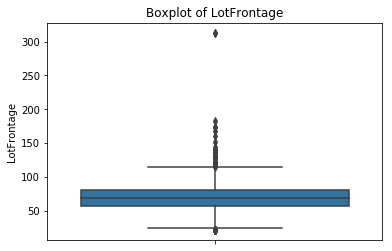

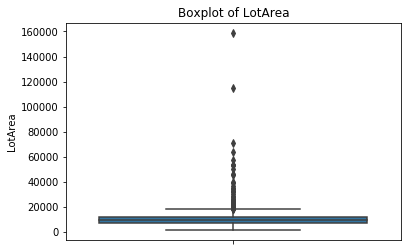

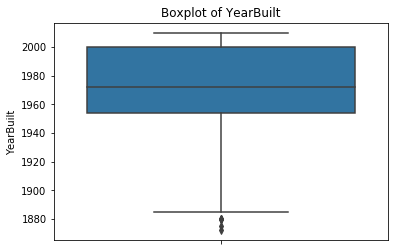

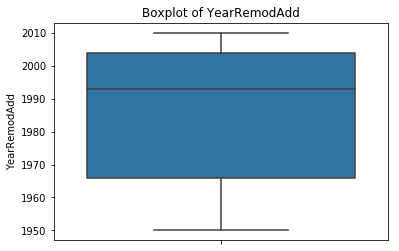

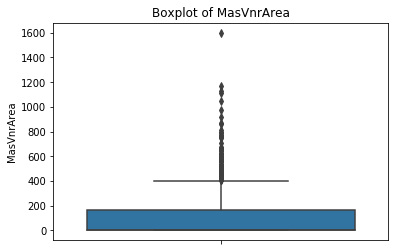

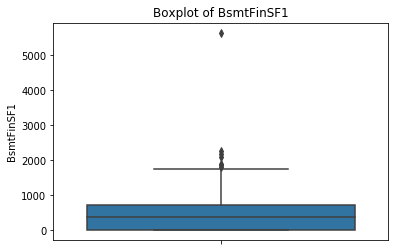

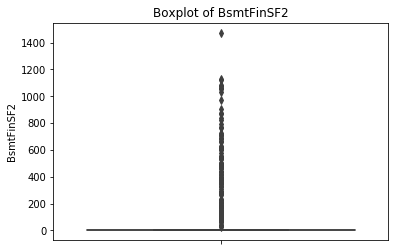

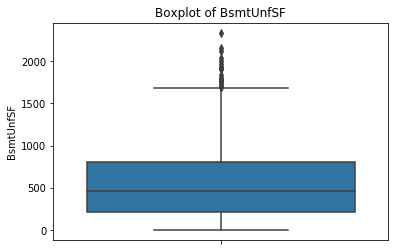

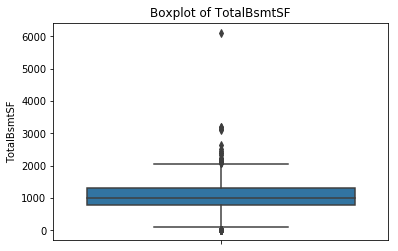

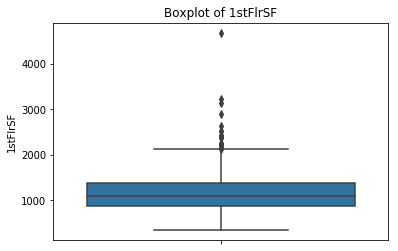

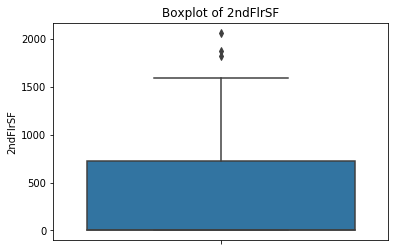

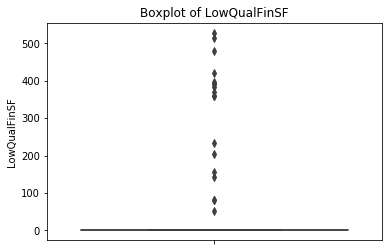

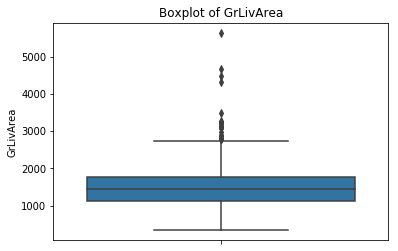

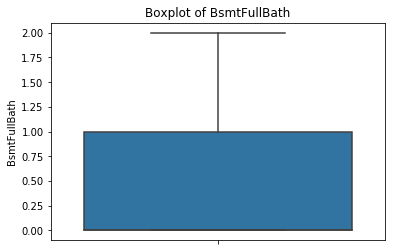

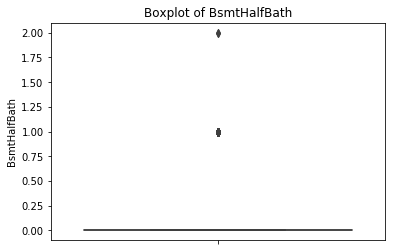

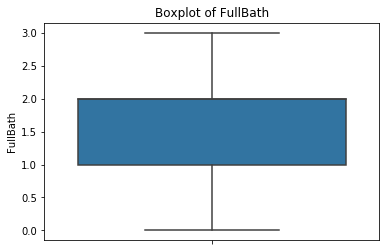

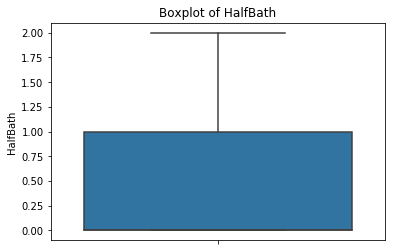

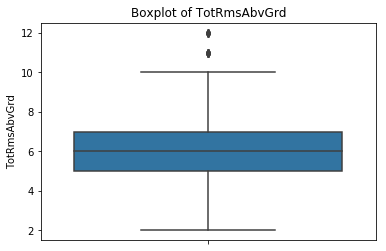

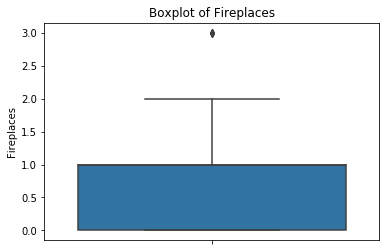

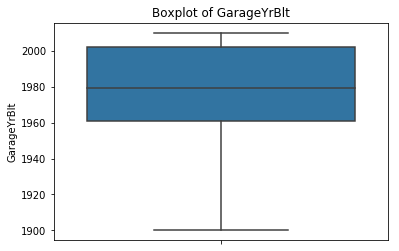

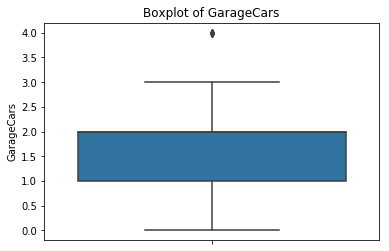

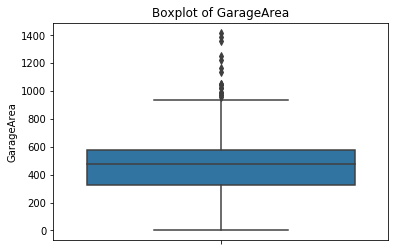

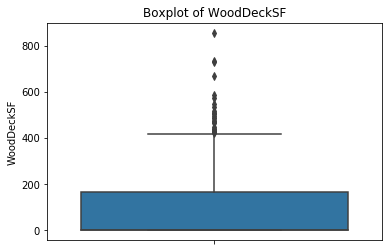

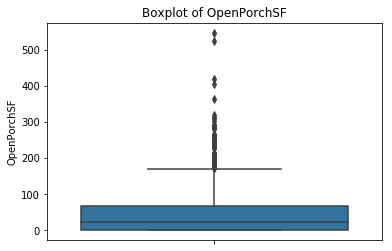

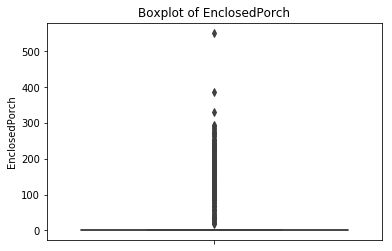

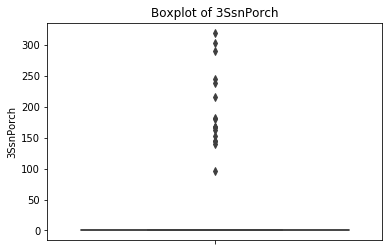

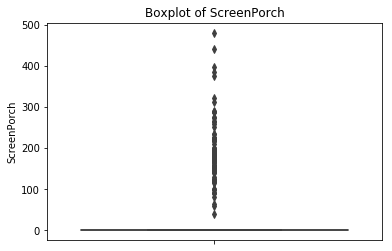

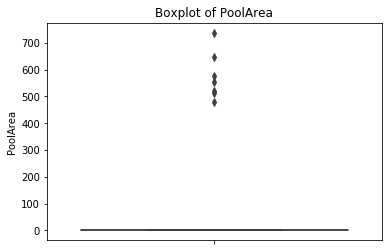

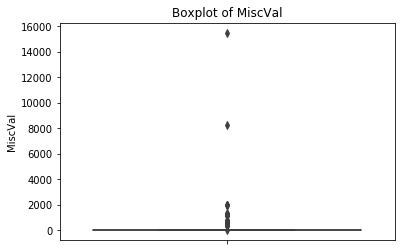

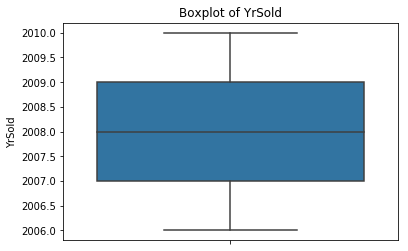

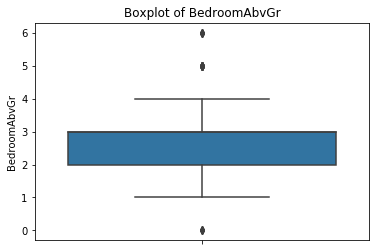

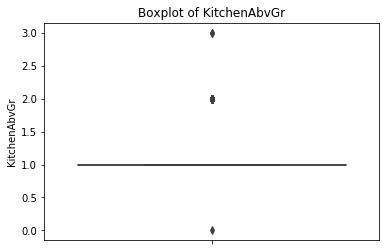

In [75]:
def box_plots(x_train, feature): 
    sns.boxplot(y = x_train[feature])
    plt.title("Boxplot of {}".format(feature))
    plt.show()
for feature in quantitative_features:
    box_plots(x_train, feature)

Histograms for quantitative features

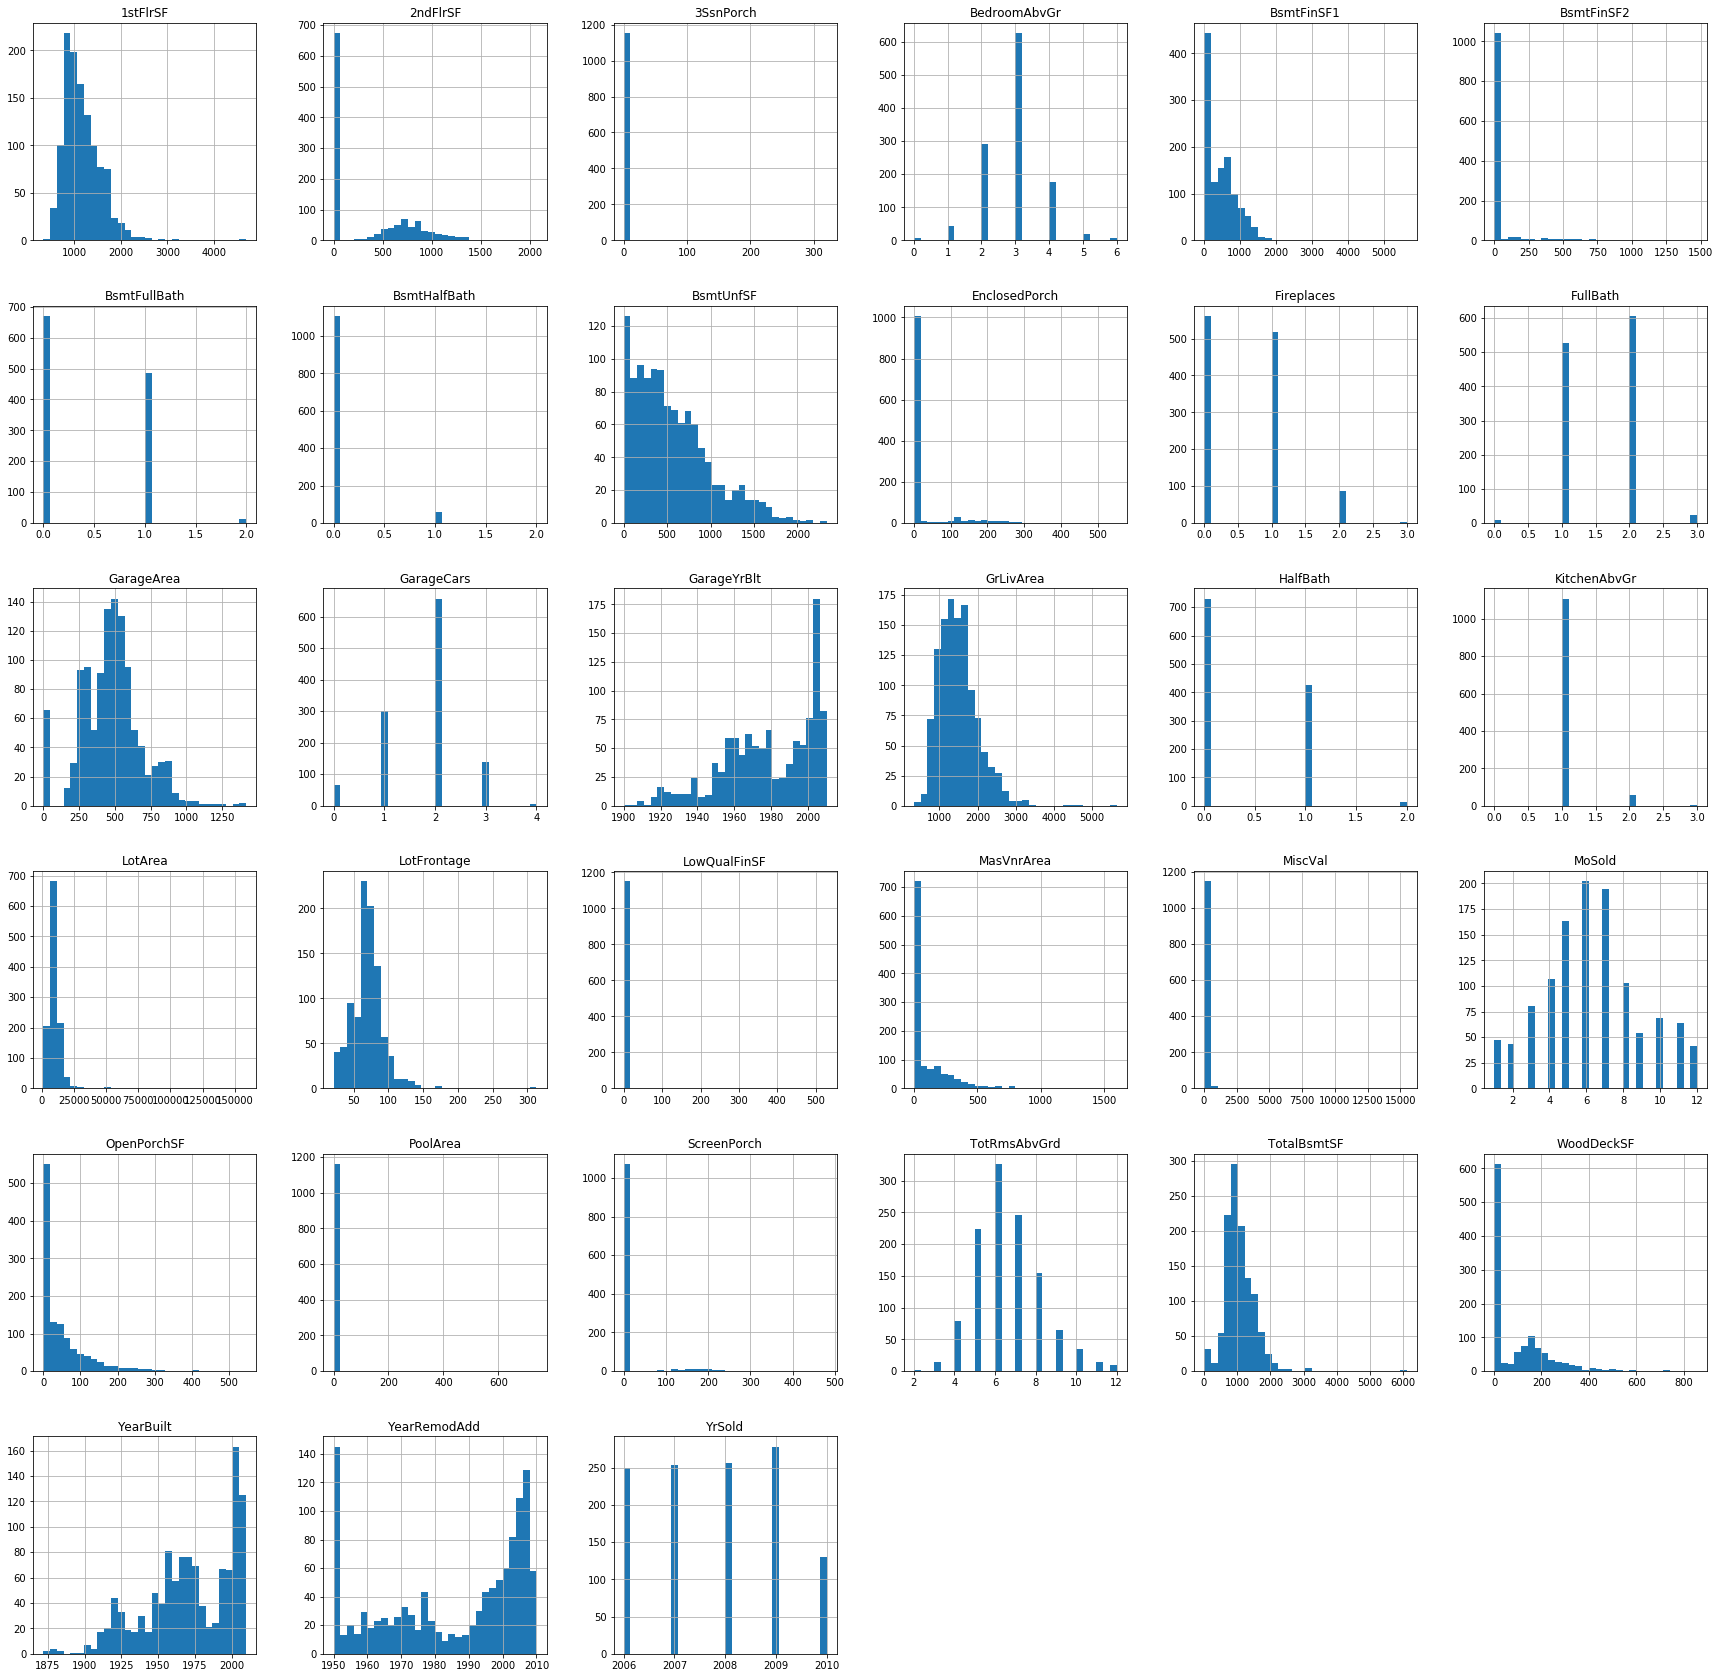

In [76]:
x_train.hist(column=quantitative_features+cyclical_features, figsize = (30, 30), bins = 30)
plt.show()

bar plots for qualitative_features, cyclical_features, binary_features, level_features

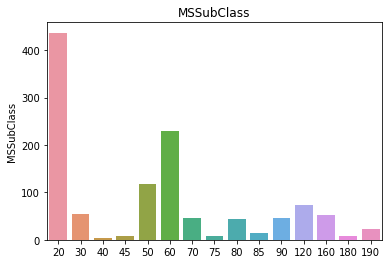

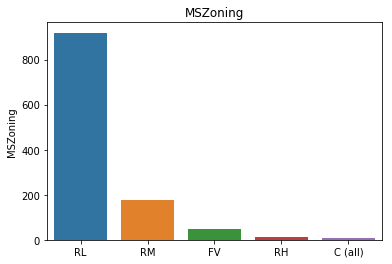

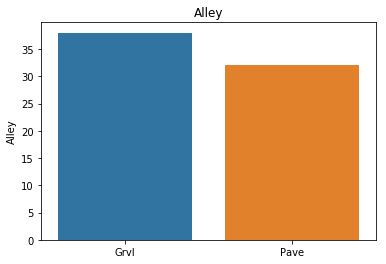

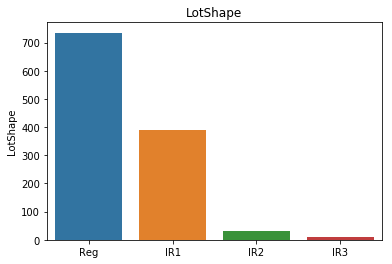

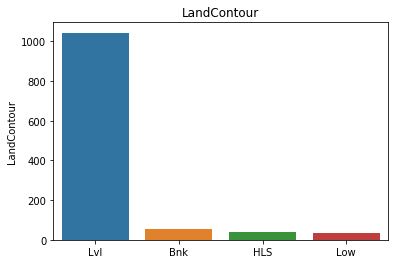

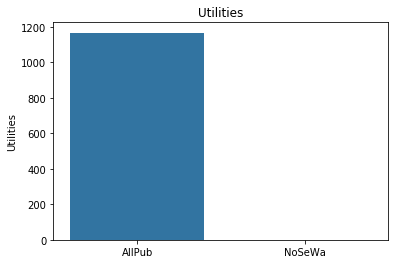

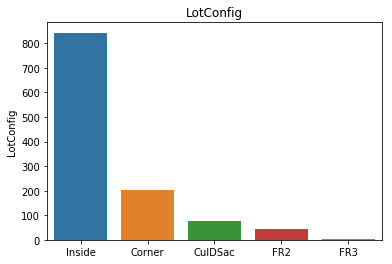

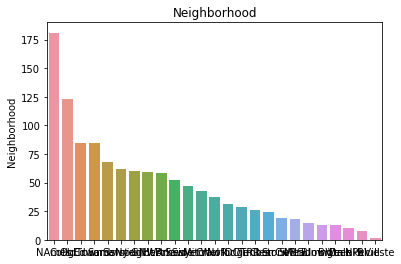

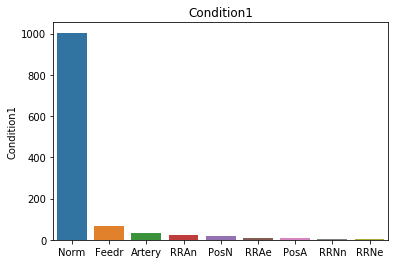

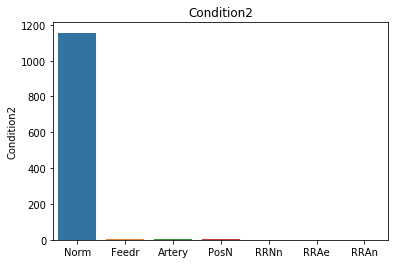

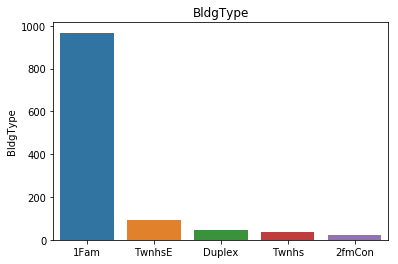

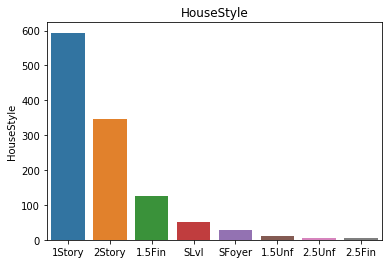

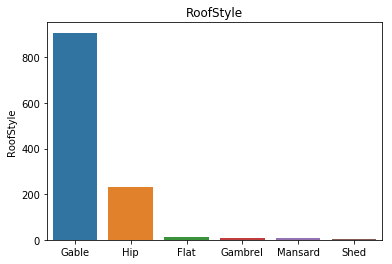

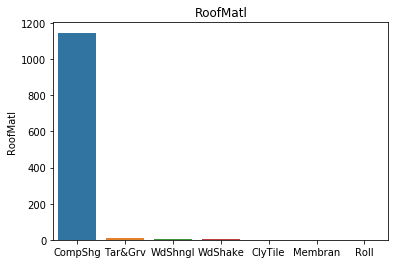

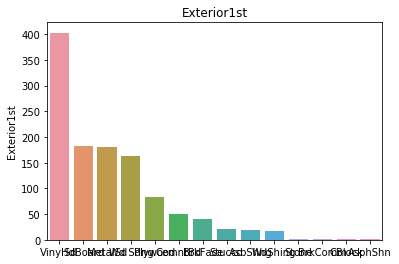

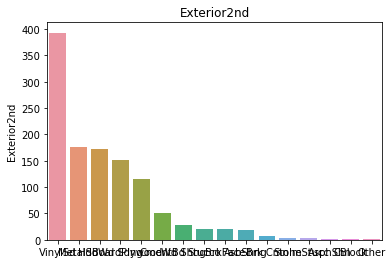

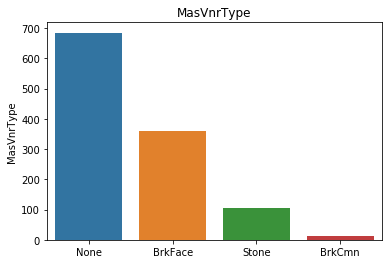

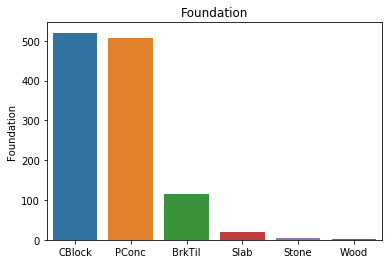

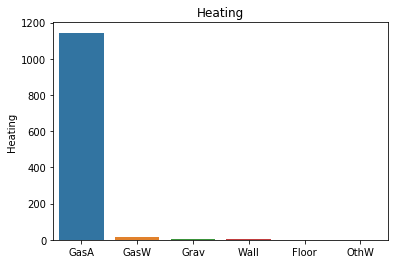

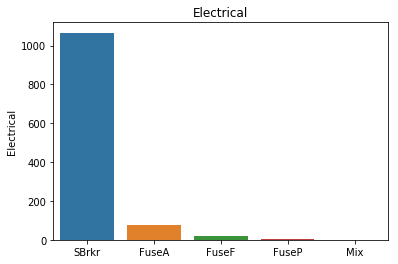

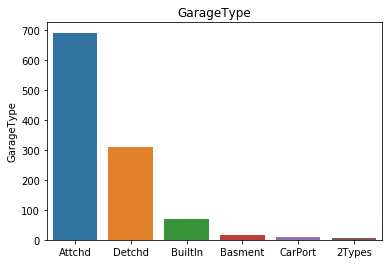

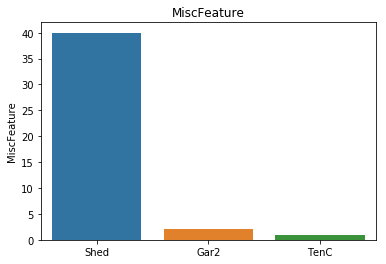

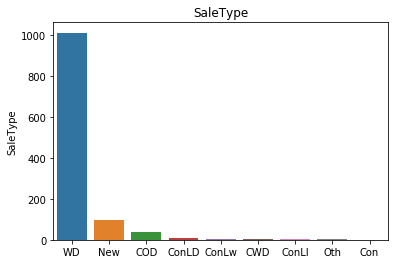

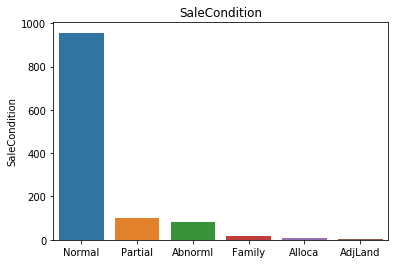

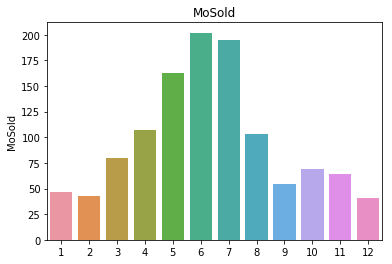

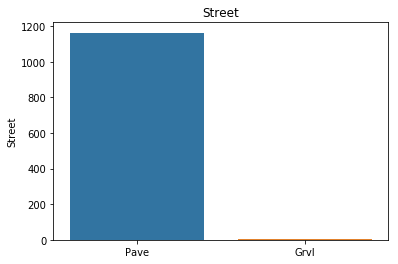

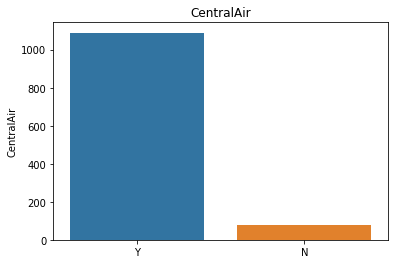

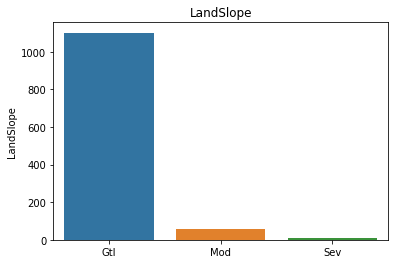

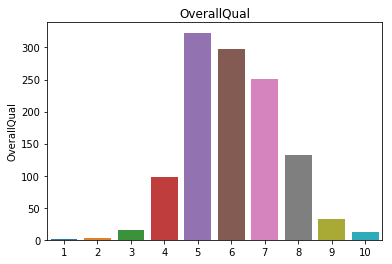

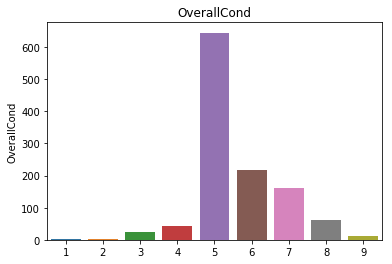

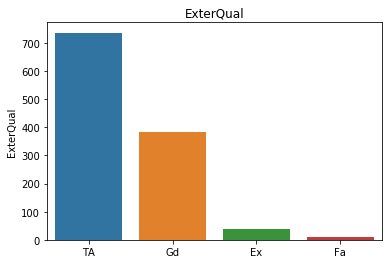

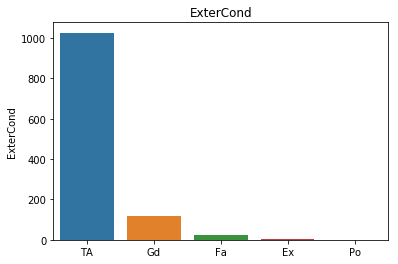

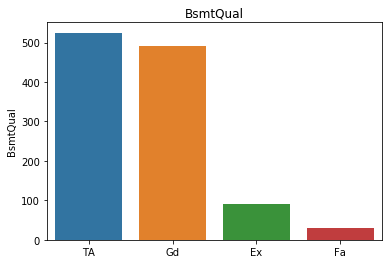

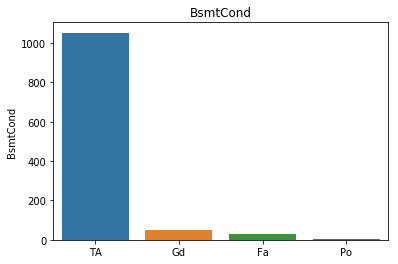

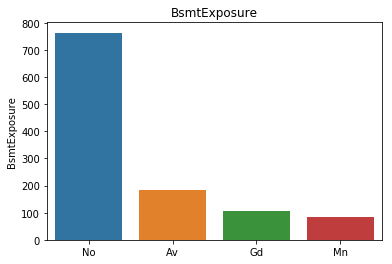

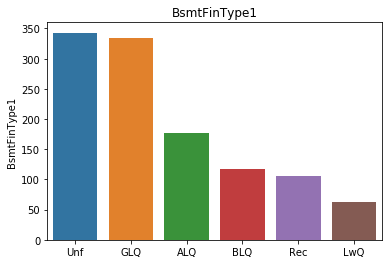

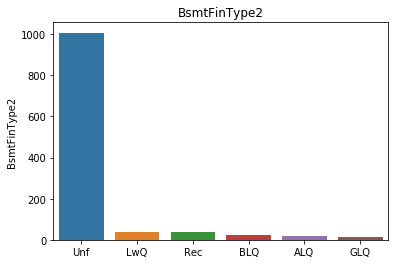

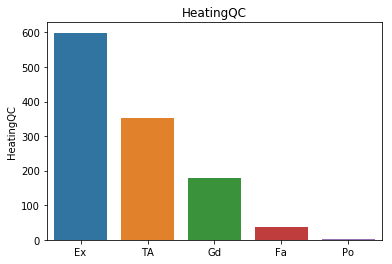

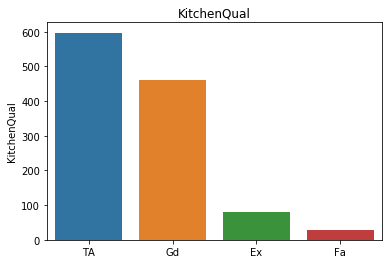

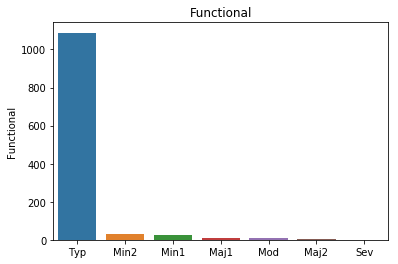

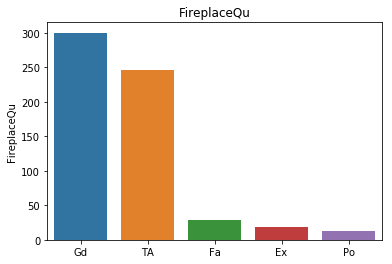

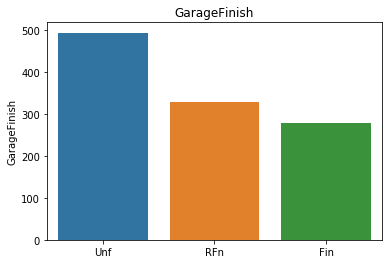

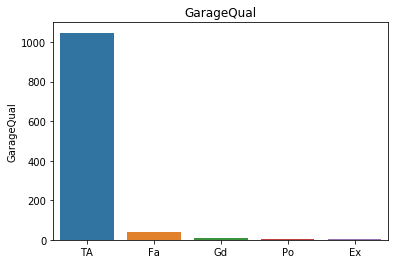

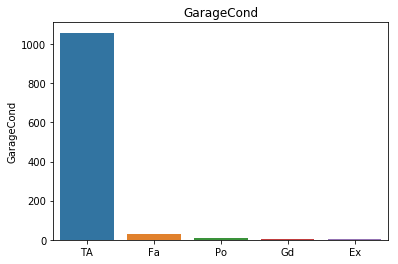

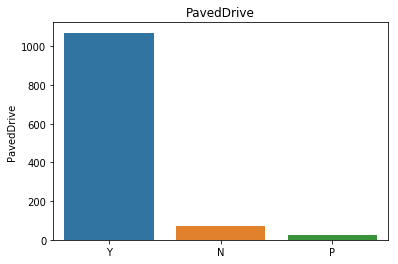

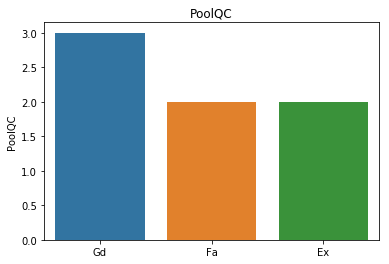

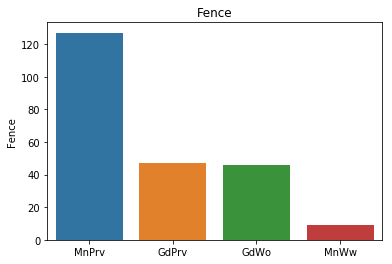

In [77]:
def bar_plots(x_train, feature):
    sns.barplot(x = x_train[feature].value_counts().index, y = x_train[feature].value_counts()).set(title = feature)
    plt.show()
for feature in qualitative_features+cyclical_features+binary_features+level_features:
    bar_plots(x_train, feature)

Cat plots for ualitative_features, cyclical_features, binary_features, level_features

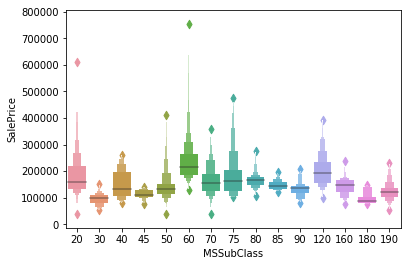

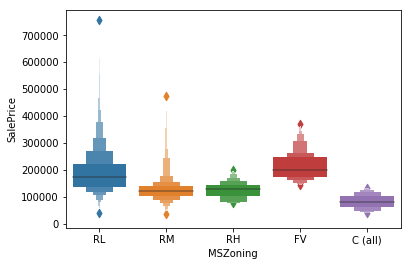

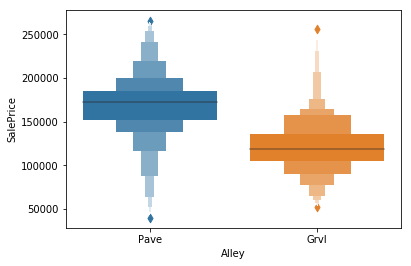

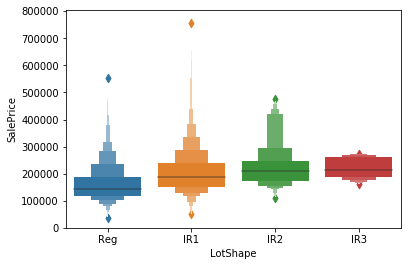

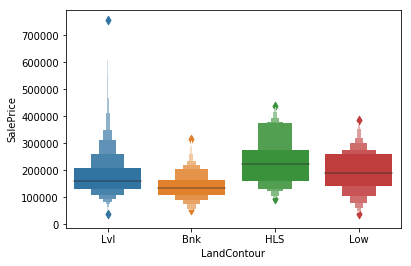

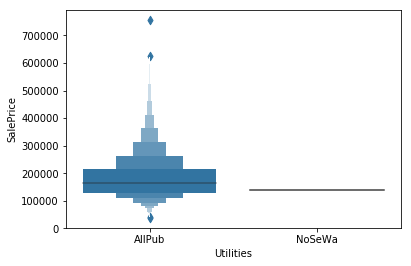

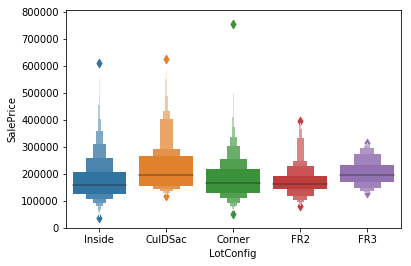

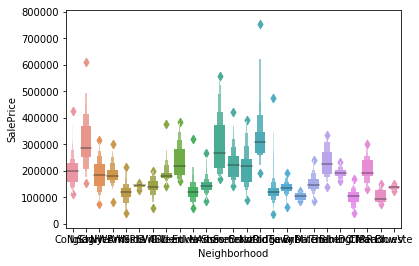

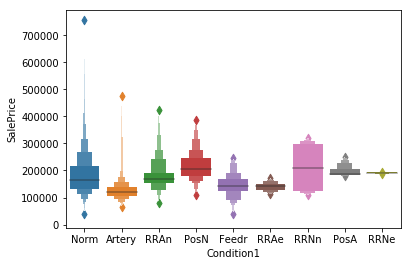

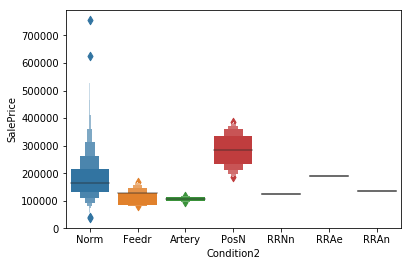

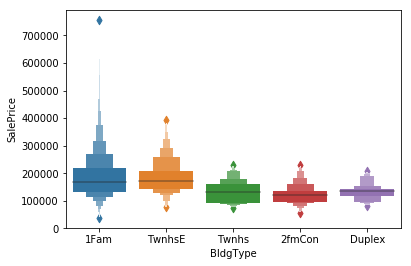

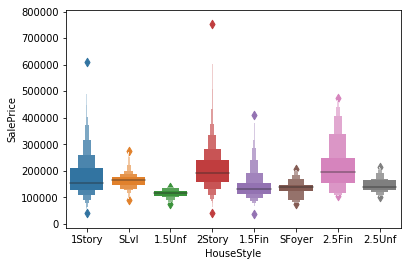

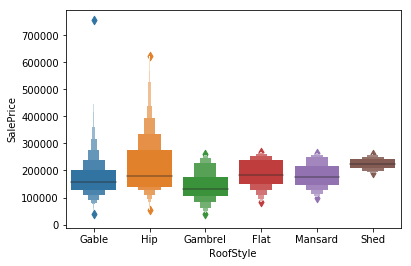

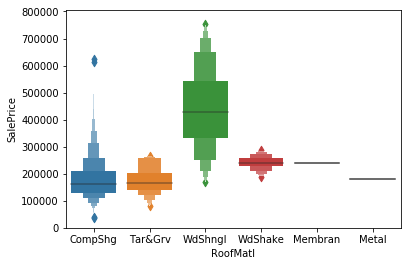

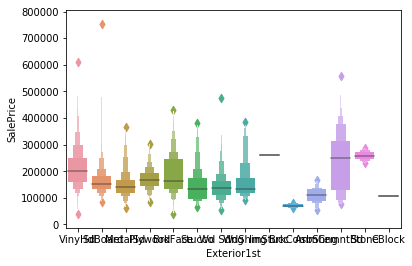

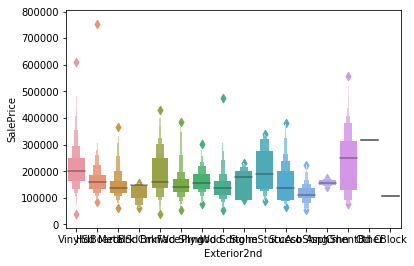

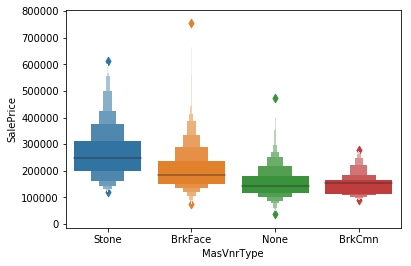

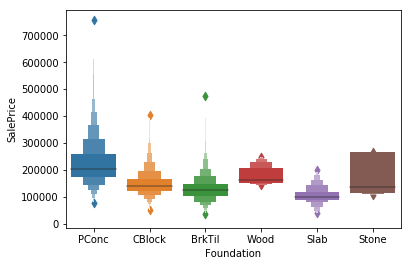

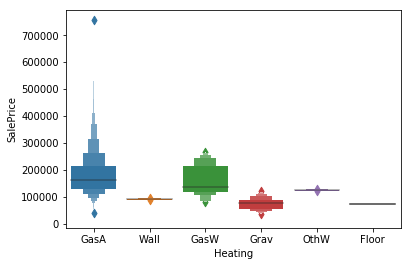

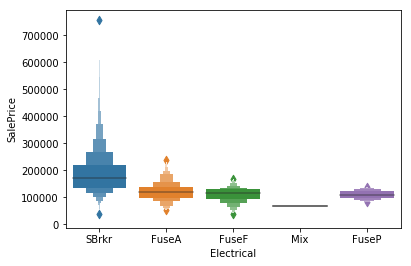

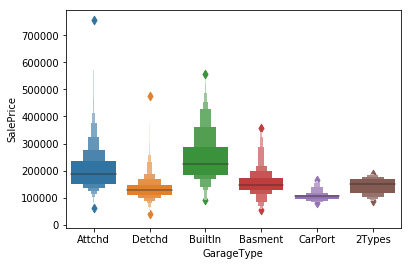

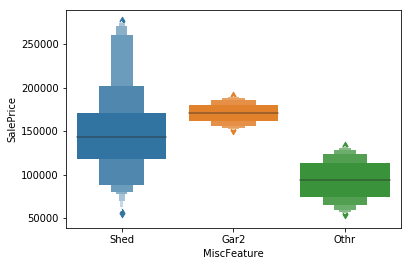

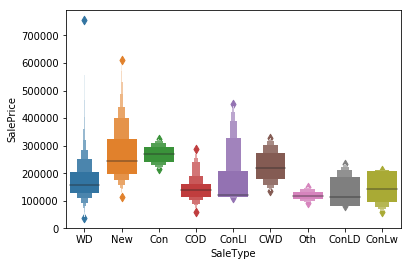

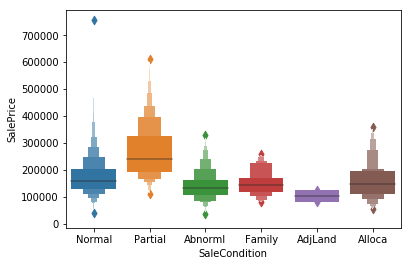

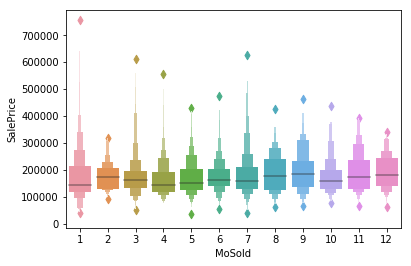

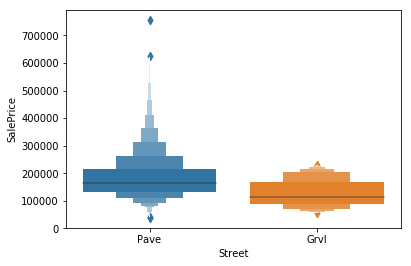

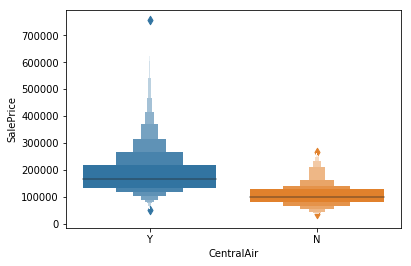

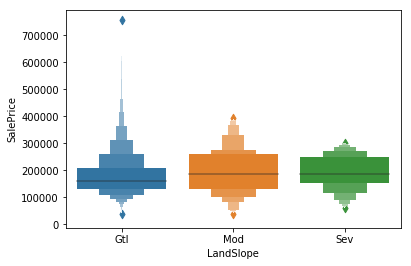

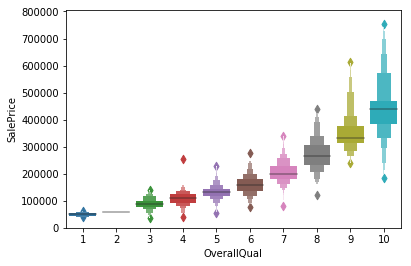

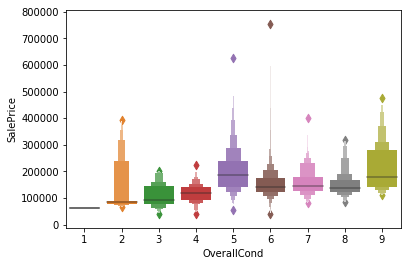

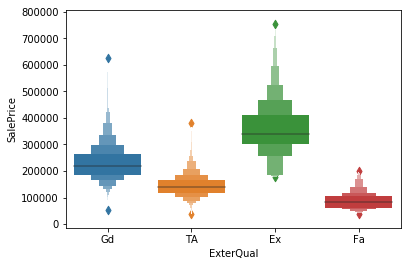

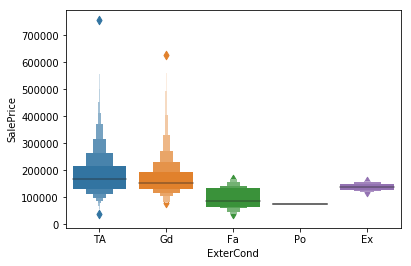

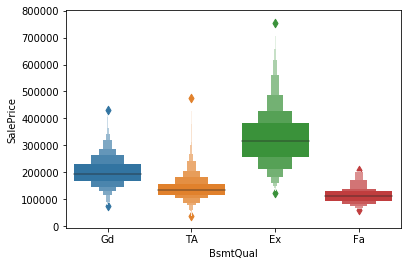

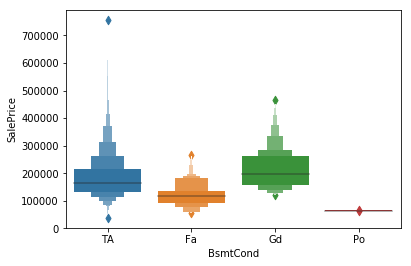

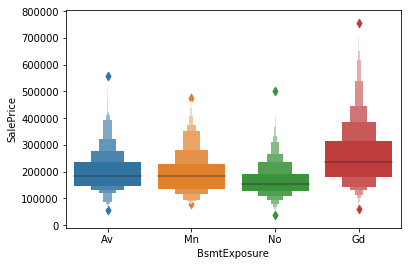

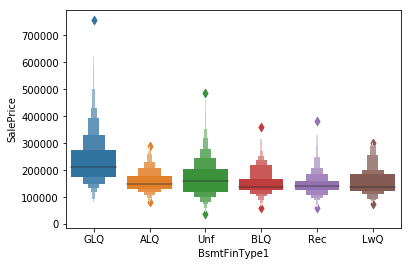

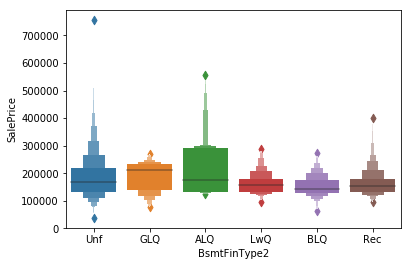

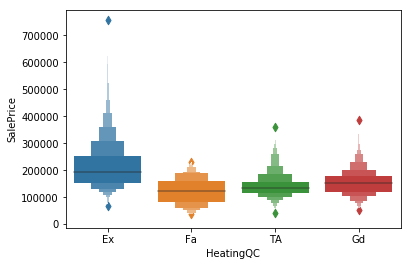

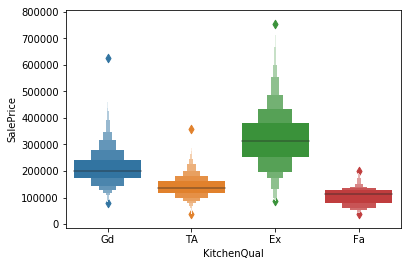

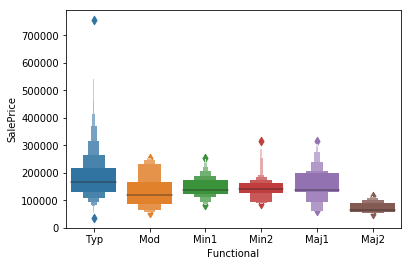

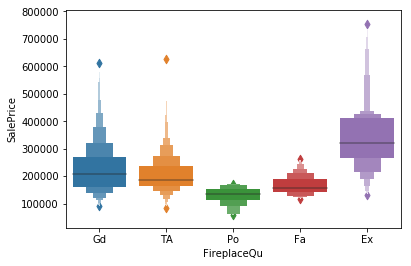

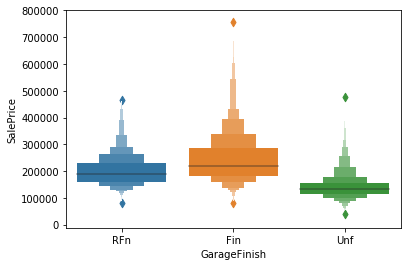

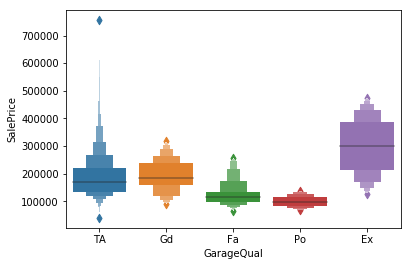

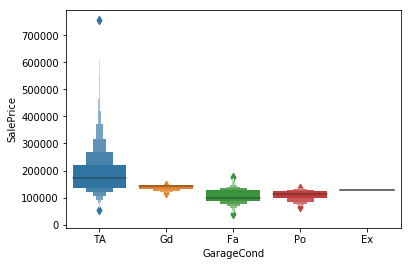

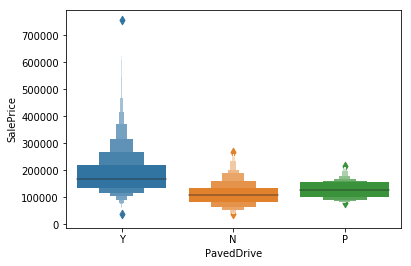

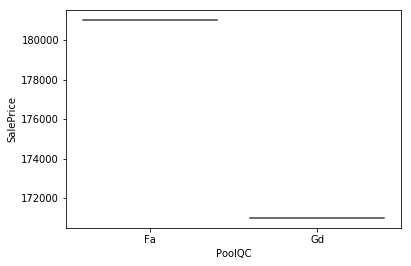

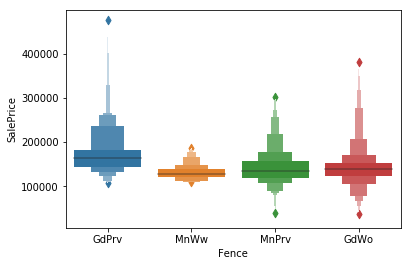

In [95]:
def cat_plots(x_y, feature):
    sns.boxenplot(x=feature, y="SalePrice", data=x_y)
    plt.show()
x_train.reset_index(drop=True, inplace=True)
x_y_train= pd.concat([x_train,pd.DataFrame(y_train, columns=["SalePrice"])],axis=1)
for feature in qualitative_features+cyclical_features+binary_features+level_features:    
    cat_plots(x_y_train, feature)

Correlation

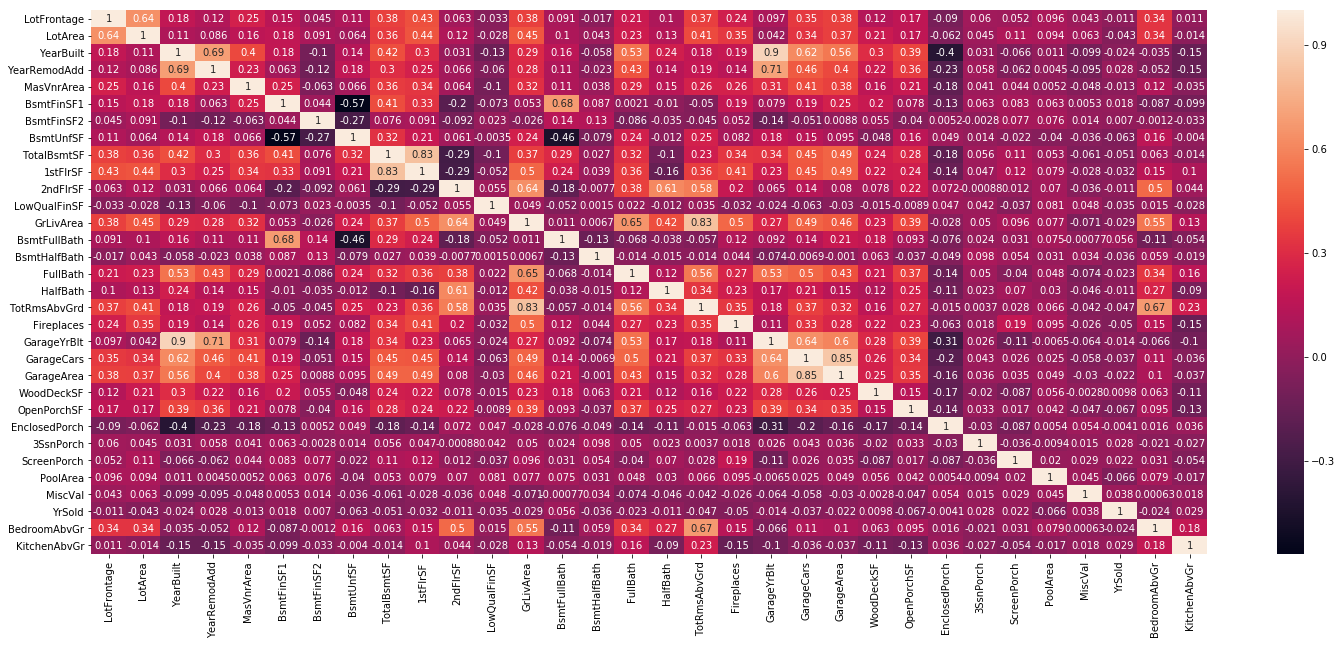

In [89]:
con_x_train=pd.DataFrame(x_train, columns=quantitative_features)
corr=con_x_train.corr(method='spearman')
plt.figure(figsize = (25, 10))
sns.heatmap(corr, annot = True)
plt.show()

Pipeline with Linear Regression

In [96]:
p_value=0.05
p=600
pipe=Pipeline([['LevelToNumericTransformer', LevelToNumericTransformer(level_features,feature_value_orders)],
               ['OutlierCorrector', OutlierCorrector(quantitative_features, level_features,p_value)],
               ['NanTransformer',NanTransformer(qualitative_features, quantitative_features, cyclical_features,
                                binary_features, level_features, p)],
               ['BinaryToNumericTransformer', BinaryToNumericTransformer(binary_features)],
               ['QualitativeToNumericTransformer',QualitativeToNumericTransformer(qualitative_features, feature_value_categories)],
               ['CyclicalToNumericTransformer',CyclicalToNumericTransformer(cyclical_features)],
               ['ScaleSacaler', StandardScaler()],
               ["LinearRegression",LinearRegression()]])
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
pipe.fit(x_train, y_train)
y_pred=pipe.predict(x_test)

Plot y_pred and y_test
Calculating mean_absolute_error,mean_absolute_percentage_error, mean_squared_error,r2

mean_absolute_error
20710.456136562556
mean_absolute_percentage_error
0.12753644681901424
mean_squared_error
1314502569.4337707
r2
0.7552155906941347


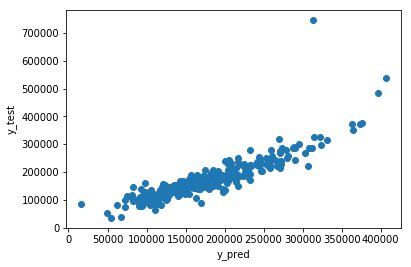

In [97]:
plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')

print('mean_absolute_error')
print(mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error')
print(mean_absolute_percentage_error(y_test, y_pred))
print('mean_squared_error')
print(mean_squared_error(y_test, y_pred))
print('r2')
print(r2_score(y_test, y_pred))

Variant 2 Pipeline with Feature Selection

In [92]:
class FeatureSelection:
    def __init__(self,w,fs_model):
        self.w=w
        self.fs_model=fs_model
        
    def fit(self, x, y=None):
        x_train=x
        y_train=y
        pipe=Pipeline([['ScaleSacaler', StandardScaler()],
                      ["fs_model",self.fs_model]]) 
        pipe.fit(x_train, y_train)
        features=x_train.columns
        weights=np.abs(pipe.named_steps['fs_model'].coef_[0])
        
        weights_index=np.argsort(weights)
        self.features=np.array(features)[weights_index[:self.w]]
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        x=x.drop(columns=self.features)
        return x

30 repetition of Pipeline with feature Selection

In [98]:
p_value=0.05
p=600
w=10
pipe=Pipeline([['LevelToNumericTransformer', LevelToNumericTransformer(level_features,feature_value_orders)],
               ['OutlierCorrector', OutlierCorrector(quantitative_features, level_features,p_value)],
               ['NanTransformer',NanTransformer(qualitative_features, quantitative_features, cyclical_features,
                                binary_features, level_features, p)],
               ['BinaryToNumericTransformer', BinaryToNumericTransformer(binary_features)],
               ['QualitativeToNumericTransformer',QualitativeToNumericTransformer(qualitative_features, feature_value_categories)],
               ['CyclicalToNumericTransformer',CyclicalToNumericTransformer(cyclical_features)],
               ['FeatureSelection',FeatureSelection(w,LinearRegression())],
               ['ScaleSacaler', StandardScaler()],
               ["LinearRegression",LinearRegression()]])

mean_absolute_error_list=[]
mean_absolute_percentage_error_list=[]
mean_squared_error_list=[]
r2_score_list=[]
for i in range(30):
    x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
    pipe.fit(x_train, y_train)
    y_pred=pipe.predict(x_test)
    mean_absolute_error_list.append(mean_absolute_error(y_test, y_pred))
    mean_absolute_percentage_error_list.append(mean_absolute_percentage_error(y_test, y_pred))
    mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
    r2_score_list.append(r2_score(y_test, y_pred))

print('mean_absolute_error')
print(np.mean(mean_absolute_error_list),np.std(mean_absolute_error_list))
print('mean_absolute_percentage_error')
print(np.mean(mean_absolute_percentage_error_list), np.std(mean_absolute_percentage_error_list))
print('mean_squared_error')
print(np.mean(mean_squared_error_list), np.std(mean_squared_error_list))
print('r2')
print(np.mean(r2_score_list),np.std(r2_score_list))


mean_absolute_error
132970630714109.39 669623842903549.5
mean_absolute_percentage_error
1263280300.6295347 6361725180.127793
mean_squared_error
6.804728282324051e+31 3.646343166777296e+32
r2
-1.1005295921589526e+22 5.900608082018493e+22
